In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect

In [4]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflect the database into a new model
Base = automap_base()

# Use the updated reflection method (autoload_with)
Base.prepare(autoload_with=engine)

# Use the inspect function to create an inspector object
inspector = inspect(engine)

# List all table names in the database
print("Available tables:", inspector.get_table_names())

# Inspect schema for each table
for table_name in inspector.get_table_names():
    print(f"\nColumns in table '{table_name}':")
    for column in inspector.get_columns(table_name):
        print(f"  {column['name']} - {column['type']}")

Available tables: ['measurement', 'station']

Columns in table 'measurement':
  id - INTEGER
  station - TEXT
  date - TEXT
  prcp - FLOAT
  tobs - FLOAT

Columns in table 'station':
  id - INTEGER
  station - TEXT
  name - TEXT
  latitude - FLOAT
  longitude - FLOAT
  elevation - FLOAT


In [6]:
# Map the tables to Python classes
Measurement = Base.classes.measurement
Station = Base.classes.station


Most Recent Date: 2017-08-23
            date  prcp
0     2016-08-24  0.08
1006  2016-08-24   NaN
1524  2016-08-24  2.15
702   2016-08-24  2.28
360   2016-08-24  2.15


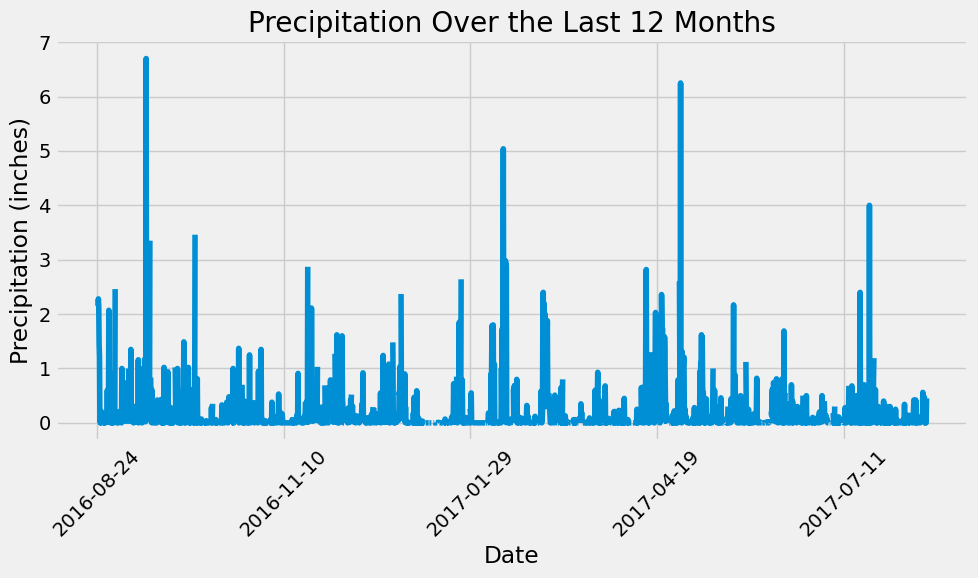

              prcp
count  2015.000000
mean      0.176462
std       0.460288
min       0.000000
25%       0.000000
50%       0.020000
75%       0.130000
max       6.700000


In [7]:
# Create a session
session = Session(engine)

# Find the most recent date in the dataset
most_recent_date = session.query(func.max(Measurement.date)).scalar()
print("Most Recent Date:", most_recent_date)

# Calculate the date one year before the most recent date
import datetime as dt
most_recent_date_dt = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
one_year_before = most_recent_date_dt - dt.timedelta(days=365)

# Query precipitation data for the last 12 months
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_before).all()

# Convert to a Pandas DataFrame
precipitation_df = pd.DataFrame(precipitation_data, columns=['date', 'prcp'])

# Sort by date
precipitation_df = precipitation_df.sort_values(by='date')

# Display the DataFrame
print(precipitation_df.head())

# Plot the precipitation data
import matplotlib.pyplot as plt

precipitation_df.plot(x='date', y='prcp', kind='line', figsize=(10, 6), legend=False)
plt.title('Precipitation Over the Last 12 Months')
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Print summary statistics
print(precipitation_df.describe())

# Close the session
session.close()


Total number of stations: 9

Active stations and their observation counts:
Station: USC00519281, Observations: 2772
Station: USC00519397, Observations: 2724
Station: USC00513117, Observations: 2709
Station: USC00519523, Observations: 2669
Station: USC00516128, Observations: 2612
Station: USC00514830, Observations: 2202
Station: USC00511918, Observations: 1979
Station: USC00517948, Observations: 1372
Station: USC00518838, Observations: 511

Most active station: USC00519281

Temperature stats for the most active station (USC00519281):
Min Temp: 54.0
Max Temp: 85.0
Avg Temp: 71.66378066378067


<Figure size 800x600 with 0 Axes>

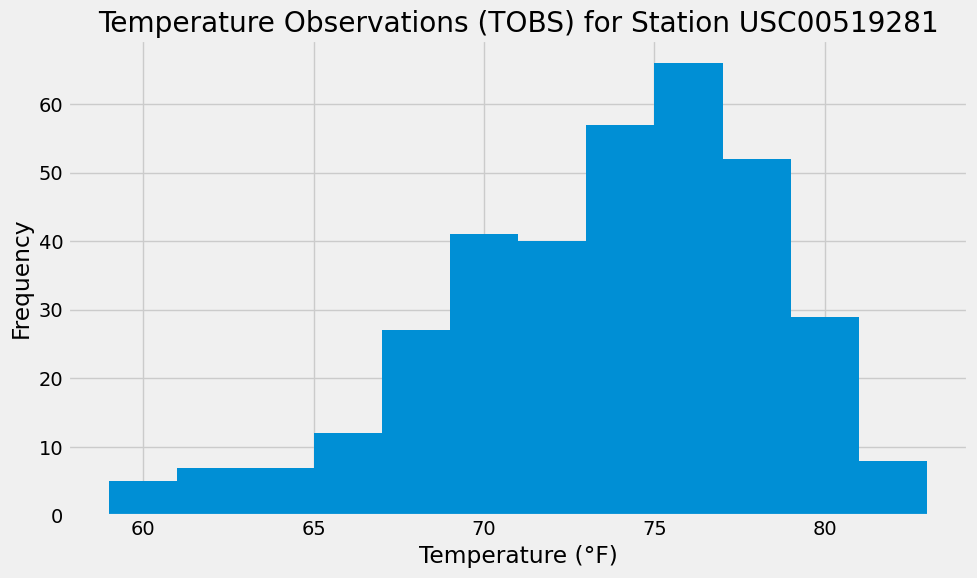

In [8]:
# Create a session
session = Session(engine)

# 1. Total number of stations
total_stations = session.query(func.count(Station.id)).scalar()
print(f"Total number of stations: {total_stations}")

# 2. Most active station (station with the most observations)
active_stations = session.query(Measurement.station, func.count(Measurement.id))\
    .group_by(Measurement.station)\
    .order_by(func.count(Measurement.id).desc()).all()

# Display all active stations and their observation counts
print("\nActive stations and their observation counts:")
for station, count in active_stations:
    print(f"Station: {station}, Observations: {count}")

# Identify the most active station
most_active_station = active_stations[0][0]
print(f"\nMost active station: {most_active_station}")

# 3. Temperature stats (min, max, avg) for the most active station
temp_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs))\
    .filter(Measurement.station == most_active_station).all()

print(f"\nTemperature stats for the most active station ({most_active_station}):")
print(f"Min Temp: {temp_stats[0][0]}")
print(f"Max Temp: {temp_stats[0][1]}")
print(f"Avg Temp: {temp_stats[0][2]}")

# 4. 12-month temperature observations (TOBS) for the most active station
tobs_data = session.query(Measurement.tobs)\
    .filter(Measurement.station == most_active_station)\
    .filter(Measurement.date >= one_year_before).all()

# Convert to a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=['tobs'])

# Plot the histogram of temperature observations
plt.figure(figsize=(8, 6))
tobs_df.plot(kind='hist', bins=12, figsize=(10, 6), legend=False)
plt.title(f'Temperature Observations (TOBS) for Station {most_active_station}')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Close the session
session.close()
